<a href="https://colab.research.google.com/github/JonasHagstrom79/PyTorch-Lightning/blob/main/03_Dueling_Deep_Q_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dueling Deep Q-Networks


In [1]:
!apt-get install -y xvfb

!pip install pygame gym==0.17.3 pytorch-lightning==1.6.0 pyvirtualdisplay

!pip install git+https://github.com/GrupoTuring/PyGame-Learning-Environment
!pip install git+https://github.com/lusob/gym-ple

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (531 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 21.8 MB 89.0 MB

###Setup viryual display

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

###Import the necessary code libraries

In [3]:
import copy
import torch
import random
import gym
import gym_ple
import matplotlib

import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [4]:
# Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
#To be able to render the envronment using a list of frames
def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

###Create the Deep Q-Network

In [5]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
    )
    #Q(State, Action) = Value((State) tells the agent how good it is to be in that state) + Advantage(State, Action)
    self.fc_value = nn.Linear(hidden_size, 1)
    self.fc_adv = nn.Linear(hidden_size, n_actions)

  def forward(self, x):
    x = self.net(x.float())
    adv = self.fc_adv(x)
    value = self.fc_value(x)
    return value + adv - torch.mean(adv, dim=1, keepdim=True)

###Create the policy

In [6]:
#fn: state -> action
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

###Create the replay buffer

In [7]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [8]:
#Create  dataset to use
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

###Create the environment

In [9]:
class RunningMeanStd:
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, "float64")
        self.var = np.ones(shape, "float64")
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )


def update_mean_var_count_from_moments(
    mean, var, count, batch_mean, batch_var, batch_count
):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class NormalizeObservation(gym.core.Wrapper):
    def __init__(
        self,
        env,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        if self.is_vector_env:
            self.obs_rms = RunningMeanStd(shape=self.single_observation_space.shape)
        else:
            self.obs_rms = RunningMeanStd(shape=self.observation_space.shape)
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        return obs, rews, dones, infos

    def reset(self, **kwargs):
        return_info = kwargs.get("return_info", False)
        if return_info:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        if not return_info:
            return obs
        else:
            return obs, info

    def normalize(self, obs):
        self.obs_rms.update(obs)
        return (obs - self.obs_rms.mean) / np.sqrt(self.obs_rms.var + self.epsilon)


class NormalizeReward(gym.core.Wrapper):
    def __init__(
        self,
        env,
        gamma=0.99,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        self.return_rms = RunningMeanStd(shape=())
        self.returns = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if not self.is_vector_env:
            rews = np.array([rews])
        self.returns = self.returns * self.gamma + rews
        rews = self.normalize(rews)
        self.returns[dones] = 0.0
        if not self.is_vector_env:
            rews = rews[0]
        return obs, rews, dones, infos

    def normalize(self, rews):
        self.return_rms.update(self.returns)
        return rews / np.sqrt(self.return_rms.var + self.epsilon)

In [10]:
env = gym_ple.make('FlappyBird-v0')

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


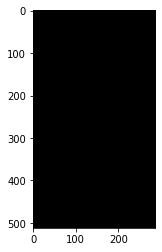

In [11]:
obs = env.reset()
plt.imshow(obs)

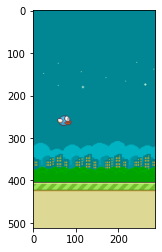

In [12]:
obs, _, _, _ = env.step(env.action_space.sample())
plt.imshow(obs)

In [13]:
env.unwrapped.game_state.getGameState()

{'next_next_pipe_bottom_y': 253,
 'next_next_pipe_dist_to_player': 449.0,
 'next_next_pipe_top_y': 153,
 'next_pipe_bottom_y': 153,
 'next_pipe_dist_to_player': 305.0,
 'next_pipe_top_y': 53,
 'player_vel': -8.0,
 'player_y': 248.0}

In [14]:
list(env.unwrapped.game_state.getGameState().values())

[248.0, -8.0, 305.0, 53, 153, 449.0, 153, 253]

In [15]:
class StateVectorWrapper(gym.Wrapper):
  
  def __init__(self, env):
    super().__init__(env)
    state = self.reset()
    self.observation_space = gym.spaces.Box(
        low=float('-inf'),
        high=float('inf'),
        shape=state.shape
    )

  def reset(self):
    super().reset()
    state_dict = self.env.unwrapped.game_state.getGameState()
    state = list(state_dict.values())
    return np.array(state)

  def step(self, action):
    _, reward, done, info = super().step(action)
    next_state_dict = self.env.unwrapped.game_state.getGameState()
    next_state = list(next_state_dict.values())
    return np.array(next_state), reward, done, info

###Create the Deep Q-Learning algorithm

###Purge logs and run the visualization tool (Tensorboard)

###Train the policy

###Check the resulting policy